# <font color='blue'>Interesting Facts Revealed about Ford GoBike</font>

### <font color='grey'>*by Lin Chen*</font>

## <font color='cornflowerblue'>Investigation Overview</font>

> Based on the dataset provided, we could have a glimpse of how the regional public bicycle sharing system runs in California's San Francisco Bay Area, as well as biking preferences in terms of location, time and duration, from users under different age and gender groups.

## <font color='cornflowerblue'>Dataset Overview</font>

> The dataset contains detailed information of all Ford GoBike tours in Feb 2019, at cities of San Francisco, San Jose and Oakland respectively. Time and location for starting point and destination, gender and age for users, as well as some other features are provided for each bike tour.

In [1]:
### loading Python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import date
import calendar
import math
%matplotlib inline

import warnings
warnings.simplefilter("ignore") # suppress warnings from final output

### data gathering and assessing

## raw data: df

df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [2]:
## clean data with missing gender and birth year values: df_clean

df_clean = df.copy() # backup

df_clean.drop(df_clean.query("start_station_id == 'NaN'").index, axis=0, inplace=True)
df_clean = df_clean.reset_index(drop=True) # drop missing values and reset index

df_clean['start_time'] = pd.to_datetime(df_clean['start_time'])
df_clean['end_time'] = pd.to_datetime(df_clean['end_time']) # date format correction
df_clean['duration_sec'] = (df_clean['end_time'] - df_clean['start_time']).dt.total_seconds() # re-calculate duration

for i in ['start_station_id', 'end_station_id', 'bike_id']:
    try:
        df_clean[i] = df_clean[i].astype(int).astype(str)
    except:
        df_clean[i] = df_clean[i].astype(str) # id format correction
        
arr = pd.array(df_clean.member_birth_year, dtype=pd.Int64Dtype())
df_clean.member_birth_year = arr # birth year format correction

df_clean['start_date'] = [d.date() for d in df_clean['start_time']]
df_clean['start_hour'] = [d.time() for d in df_clean['start_time']]
df_clean['end_date'] = [d.date() for d in df_clean['end_time']]
df_clean['end_hour'] = [d.time() for d in df_clean['end_time']] # add columns indicating start date and hour

sd = []
for i in df_clean.start_time:
    sd.append(i.isoweekday())
df_clean['start_day'] = sd # add column to indicate weekday or weekend

total = df_clean.shape[0]
city_s = []
city_list = ['San Francisco', 'Oakland', 'San Jose']
for i in range(total):
    if df_clean.start_station_longitude[i]>-122.1:
        city_s.append(city_list[2])
    elif df_clean.start_station_longitude[i]<-122.35:
        city_s.append(city_list[0])
    else:
        city_s.append(city_list[1])
df_clean['start_city'] = city_s # add column to indicate city

In [3]:
## clean data without missing value: df_clean1

df_clean1 = df_clean.dropna()
df_clean1 = df_clean1.reset_index(drop=True)

In [4]:
## a separate dataset for stations: df_station

a = df_clean.groupby(['start_station_id']).start_station_name.first()
b = df_clean.groupby(['start_station_id']).start_station_longitude.mean()
c = df_clean.groupby(['start_station_id']).start_station_latitude.mean()
d = df_clean.groupby(['start_station_id']).start_station_name.agg('count')
e = df_clean.groupby(['end_station_id']).end_station_name.agg('count')
f = df_clean.groupby(['start_station_id']).start_city.first()
data = {'name':a, 'longi':b, 'lati':c, 'start':d, 'end':e, 'total':d+e, 'net':e-d, 'city':f}
df_station = pd.DataFrame(data, columns = ['name', 'longi', 'lati', 'start', 'end', 'total', 'net', 'city'])

type = []
for i in range(df_station.shape[0]):
    if df_station['net'][i] < -10:
        type.append('out')
    elif df_station['net'][i] > 10:
        type.append('in')
    else:
        type.append('equal')
df_station['type'] = type

In [5]:
## a separate dataset for gender: df_gender

male_pct=[]
female_pct=[]
other_pct=[]
cities = ['San Francisco', 'Oakland', 'San Jose']
colors = ['royalblue', 'cornflowerblue', 'lightsteelblue']
colors1 = ['red', 'orange', 'yellow']

for i in cities:
    citydata = df_clean1[df_clean1.start_city == i]
    a = citydata[citydata.member_gender == 'Male'].shape[0]/citydata.shape[0]
    b = citydata[citydata.member_gender == 'Female'].shape[0]/citydata.shape[0]
    c = 1-a-b
    male_pct.append(a)
    female_pct.append(b)
    other_pct.append(c)
data = {'male':male_pct, 'female':female_pct, 'other':other_pct}
df_gender = pd.DataFrame(data, columns = ['male', 'female', 'other'])
df_gender.index = cities

## <font color='cornflowerblue'>Biking Duration</font>
> <li>Due to some super long-time biking activities, the duration distribution is right-skewed.</li><li>In February 2019, there were 56 bike tours lasted longer than 16 hours, the longest one lasted for almost 24 hours.</li><br>
> <li>However, around 60% of bike tours only have duration between 5 and 15 minutes.</li><li>Median for biking duration is 8.6 minutes, while the average duration is 12.1 minutes due to those large outliers.</li>

Longest bike tour: 23.73 hr
Bike tours longer than 16 hr happened 56 times in Feb 2019
Bike tours longer than 4 hr: 0.16 %
Bike tours longer than 1 hr: 0.93 %
Bike tours longer than 30 min: 3.69 %
--------------------------------------------
Bike tours between 5 min and 15 min: 59.31 %


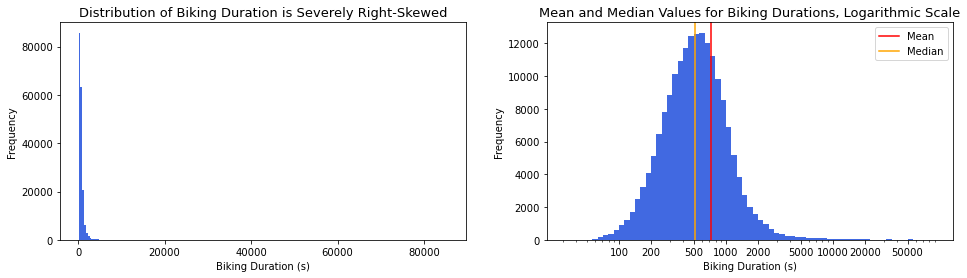

In [6]:
print('Longest bike tour:', round(df_clean.duration_sec.max()/3600, 2), 'hr')
print('Bike tours longer than 16 hr happened', round(df_clean.query("duration_sec>57600").shape[0]), 'times in Feb 2019')
print('Bike tours longer than 4 hr:', round(df_clean.query("duration_sec>14400").shape[0]/total*100, 2), '%')
print('Bike tours longer than 1 hr:', round(df_clean.query("duration_sec>3600").shape[0]/total*100, 2), '%')
print('Bike tours longer than 30 min:', round(df_clean.query("duration_sec>1800").shape[0]/total*100, 2), '%')
print('--------------------------------------------')
print('Bike tours between 5 min and 15 min:', round(df_clean.query("900>=duration_sec>=300").shape[0]/total*100, 2), '%')

plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1)
plt.hist(data = df_clean, x = 'duration_sec', bins=200, color=['royalblue']);
plt.xlabel('Biking Duration (s)');
plt.ylabel('Frequency');
plt.title('Distribution of Biking Duration is Severely Right-Skewed', fontsize=13);

plt.subplot(1, 2, 2)
bins = 10**np.arange(1.5, 5, 0.05)
plt.hist(data = df_clean, x = 'duration_sec', bins=bins, color=['royalblue']);
plt.xscale('log')
ticks = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
labels = ['{}'.format(h) for h in ticks]
plt.xticks(ticks, labels);
avg = plt.axvline(726.401111, color='red');
med = plt.axvline(514.489000, color='orange');
plt.xlabel('Biking Duration (s)');
plt.ylabel('Frequency');
plt.title('Mean and Median Values for Biking Durations, Logarithmic Scale', fontsize=13);
plt.legend([avg, med], ['Mean', 'Median']);

## <font color='cornflowerblue'>Day for Biking</font>
*There are 28 days in February 2019, and each day in a week contains 4 different days, so it's fair to carry out a direct comparison between 7 different days in a week without using weighted averages.*
> <li>Based on the pie chart, only 16.85% of the recorded biking tours started on weekends.</li><li>Thursday has most biking tours, while Saturday and Sunday have the least.</li><li>Average bike tour activities on a single weekday is around 2 times of biking tours on a single weekend.</li><li>There are more long-time biking tours happened during weekends, which resulted in higher Q3 values.</li>

*Outliers are removed in the boxplot, since there are too much of them.*

On each weekend, there are 15440 bike tours on average.
On each weekday, there are 30467 bike tours on average.
--------------------------------------------------------------
Bike tours on a weekday is approximately 2 times of a weekend.


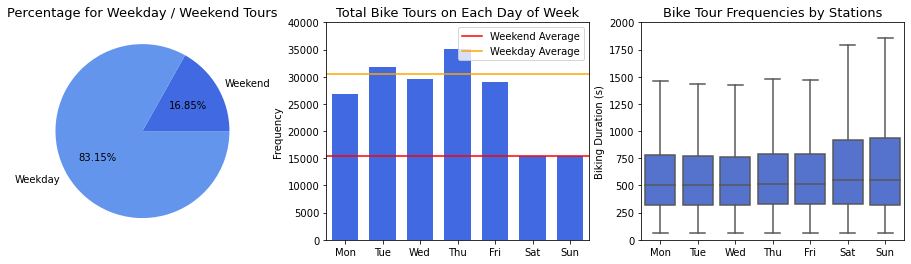

In [7]:
weekday = df_clean.query("start_day != [6, 7]")
weekend = df_clean.query("start_day == [6, 7]")
avg1 = weekend.shape[0]/2
avg2 = weekday.shape[0]/5
print('On each weekend, there are', round(avg1), 'bike tours on average.')
print('On each weekday, there are', round(avg2), 'bike tours on average.')
print('--------------------------------------------------------------')
print('Bike tours on a weekday is approximately', round(avg2/avg1), 'times of a weekend.')

plt.figure(figsize=(16, 4));

plt.subplot(1, 3, 1)
weekend_count = weekend.shape[0]/total
weekday_count = 1-weekend_count
plt.pie([weekend_count, weekday_count], labels=['Weekend', 'Weekday'], 
        autopct='%1.2f%%', colors=colors);
plt.title('Percentage for Weekday / Weekend Tours', fontsize=13);

plt.subplot(1, 3, 2)
plt.hist(df_clean.start_day, bins=np.arange(9)-0.5, rwidth = 0.7, color=['royalblue']);
plt.xlim((0.5,7.5));
plt.axhline(avg1, color='red');
plt.axhline(avg2, color='orange');
plt.legend([avg1, avg2], labels = ['Weekend Average', 'Weekday Average']);
plt.ylabel('Frequency');
plt.ylim((0, 40000));
plt.title('Total Bike Tours on Each Day of Week', fontsize=13);
plt.xticks(np.arange(7)+1, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

plt.subplot(1, 3, 3)
flierprops = dict(marker='')
sb.boxplot(data = df_clean, x = 'start_day', y = 'duration_sec', color = 'royalblue', flierprops=flierprops);
plt.title('Bike Tour Frequencies by Stations', fontsize=13);
plt.ylim((0, 2000));
plt.xlabel('');
plt.ylabel('Biking Duration (s)');
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

## <font color='cornflowerblue'>Hour for Biking</font>
> <li>During weekdays, there are two clear peaks on histogram, at 8 and 17 respectively.</li><li>It's not surprising since 8 AM and 5 PM are two rush hours for people going to work/school and back home.</li><br>
> <li>During weekends, there is only one vague peak on histogram at around 13 and 14.</li><li>There is more flexibility for people's schedule on weekend, and the distribution curve looks more smooth.</li><li>1 or 2 PM after lunch are be the busiest biking hours, perhaps due to more sunshine and high temperature for days in February.</li>

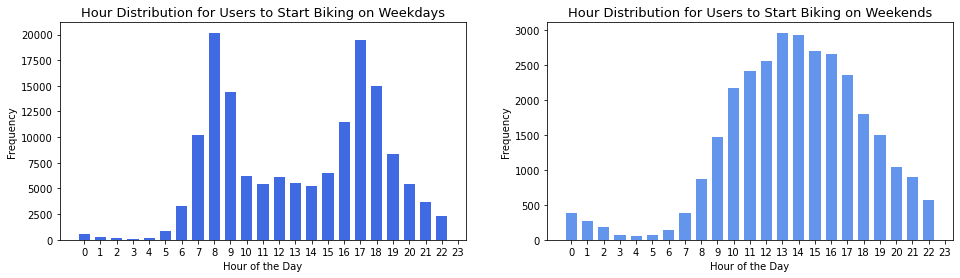

In [8]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1) 
sh1 = []
for i in weekday.start_time: # for weekday
    sh1.append(i.hour)
plt.hist(sh1, bins=np.arange(24)-0.5, rwidth = 0.7, color=['royalblue']);
ticks = np.arange(24)
labels = ['{}'.format(h) for h in ticks]
plt.xticks(ticks, labels);
plt.title('Hour Distribution for Users to Start Biking on Weekdays', fontsize=13);
plt.ylabel('Frequency');
plt.xlabel('Hour of the Day');

plt.subplot(1, 2, 2) 
sh2 = []
for i in weekend.start_time: # for weekend
    sh2.append(i.hour)
plt.hist(sh2, bins=np.arange(24)-0.5, rwidth = 0.7, color=['cornflowerblue']);
ticks = np.arange(24)
labels = ['{}'.format(h) for h in ticks]
plt.xticks(ticks, labels);
plt.title('Hour Distribution for Users to Start Biking on Weekends', fontsize=13);
plt.ylabel('Frequency');
plt.xlabel('Hour of the Day');

## <font color='cornflowerblue'>Places for Biking</font>
### <font color='lightsteelblue'>Part 1</font>
> <li>Based on the longitudes and latitudes provided, bike stations are located in three cities: San Francisco, Oakland and San Jose.</li><li>For each single bike tour, stations for start and end are all in same city, which means nobody ride bike from one city to another.</li><br>
> <li> <font color='royalblue'>Total bike tours:</font> 73% in San Francisco, 23% in Oakland, 4% in San Jose.</li><li><font color='royalblue'>Bike station numbers:</font> 47% in San Francisco, 39% in Oakland, 14% in San Jose.</li><li>Based on the violin plot, bike stations in San Francisco are busiest, followed by Oakland and then San Jose.</li>

Average bike tours for each station:
-----------------------------------
San Francisco: 857
Oakland: 326
San Jose: 176


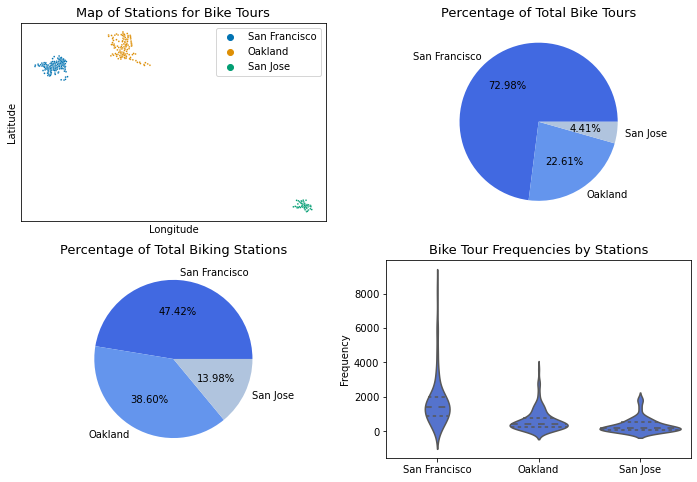

In [9]:
biketours=[]
locations=[]

for i in np.arange(3):
    biketours.append(df_clean[df_clean.start_city == cities[i]].shape[0])
    locations.append(df_station[df_station.city == cities[i]].shape[0])
    
city_data = pd.DataFrame(cities, index = np.arange(3), columns = ['name'])
city_data['tour'] = biketours
city_data['location'] = locations # build a small dataframe for plotting

plt.figure(figsize=(12, 8));

plt.subplot(2, 2, 1)
sb.scatterplot(data = df_station, x = 'longi', y = 'lati', hue = 'city', s = 3 , palette = 'colorblind');
plt.xticks([]);
plt.yticks([]);
plt.title('Map of Stations for Bike Tours', fontsize=13);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.legend();

plt.subplot(2, 2, 2)
plt.pie(city_data['tour'], labels=city_data['name'],  autopct='%1.2f%%', 
        colors=colors); 
plt.title('Percentage of Total Bike Tours', fontsize=13);

plt.subplot(2, 2, 3)
plt.pie(city_data['location'], labels=city_data['name'],  autopct='%1.2f%%', 
        colors=colors); 
plt.title('Percentage of Total Biking Stations', fontsize=13);

plt.subplot(2, 2, 4)
sb.violinplot(data = df_station, x = 'city', y = 'total', inner = 'quartile', color = 'royalblue');
plt.title('Bike Tour Frequencies by Stations', fontsize=13);
plt.xlabel('');
plt.ylabel('Frequency');

print('Average bike tours for each station:')
print('-----------------------------------')
for i in np.arange(3):
    print(city_data['name'][i]+':', round(city_data['tour'][i]/city_data['location'][i]))

## <font color='cornflowerblue'>Places for Biking</font>
### <font color='lightsteelblue'>Part 2</font>
> Based on the colored map, most frequent regions for biking are:</li>
1. Northeastern part of San Francisco
2. Northeastern part of Oakland
3. Southeastern part of San Jose

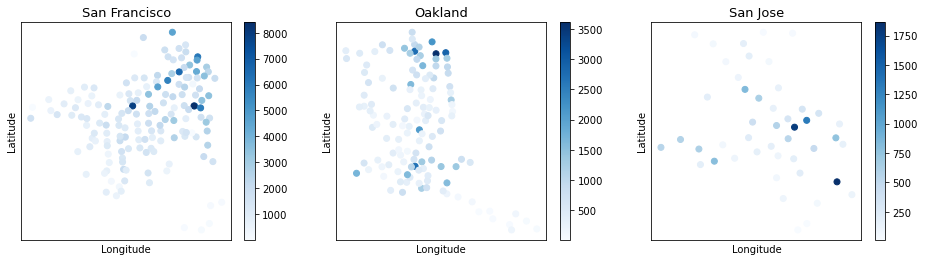

In [10]:
plt.figure(figsize=(16, 4));

for i in np.arange(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(data = df_station[df_station.city == cities[i]], x = 'longi', y = 'lati', c = 'total', cmap = 'Blues');
    plt.xticks([]);
    plt.yticks([]);
    plt.title(cities[i], fontsize=13);
    plt.xlabel('Longitude');
    plt.ylabel('Latitude');
    plt.colorbar();

## <font color='cornflowerblue'>Places for Biking</font>
### <font color='lightsteelblue'>Part 3</font>
> <li>In terms of median values for biking duration, San Francisco is longest, followed by San Jose and Oakland.</li><li>However for average values, though users in San Francisco biking for longest time, this time Oakland ranks the second.</li><li>The reason for different rankings of medians and means is, biking duration distribution for Oakland is relatively right-skewed than others.</li>

*Outliers are removed in the boxplot, since there are too much of them.*

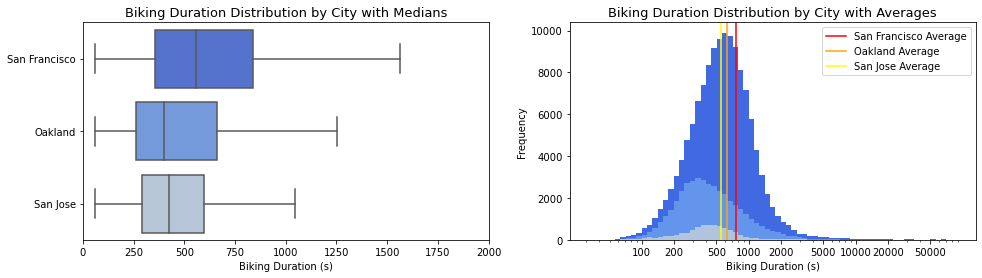

In [11]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1)
flierprops = dict(marker='')
sb.boxplot(data=df_clean, y='start_city', x='duration_sec',
           palette=colors, flierprops=flierprops); 
plt.xlim((0, 2000));
plt.ylabel('');
plt.xlabel('Biking Duration (s)');
plt.title('Biking Duration Distribution by City with Medians', fontsize=13);

plt.subplot(1, 2, 2)
avr = []
bins = 10**np.arange(1.5, 5, 0.05)
for i in range(3):
    a = df_clean[df_clean.start_city == cities[i]]
    plt.hist(data = a, x = 'duration_sec', bins=bins, color=colors[i]);
    b = a.duration_sec.mean()
    avr.append(b)
    plt.axvline(b, color=colors1[i]);
plt.xscale('log')
ticks = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
labels = ['{}'.format(h) for h in ticks]
plt.xticks(ticks, labels);
plt.xlabel('Biking Duration (s)');
plt.ylabel('Frequency');
plt.legend(avr, labels = ['San Francisco Average', 'Oakland Average', 'San Jose Average']);
plt.title('Biking Duration Distribution by City with Averages', fontsize=13);

## <font color='cornflowerblue'>GoBike User Age</font>
*For GoBiker users who were born before 1930, they will be older than 90 years old in Feb 2019. Therefore, those information shall be temperarily removed for age analysis, since users might provide wrong age values.*
> <li>The average age for users is 34 years old (born in 1985).</li><li>Young generations born between 1985 and 1995 are main users of GoBike, with age from 24 to 34.</li><li>Generally speaking, under a younger age, the maximum biking duration tends to be longer.</li>

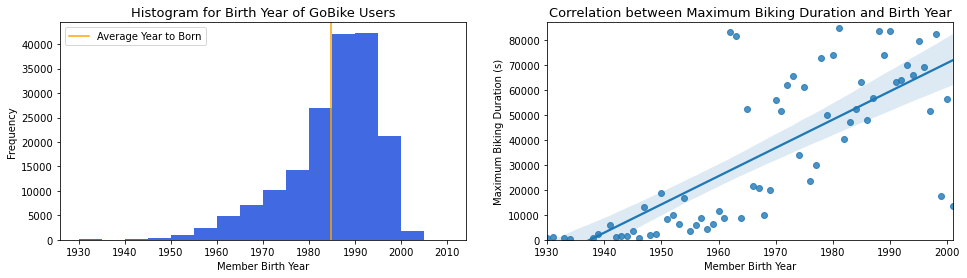

In [13]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1)
bins = np.arange(1930, 2011, 5)
birth_year = df_clean1['member_birth_year']
plt.hist(birth_year, bins=bins, color=['royalblue']);
avg_yr = birth_year[birth_year>=1930].mean()
plt.axvline(avg_yr, color='orange');
plt.legend([avg_yr], labels = ['Average Year to Born']);
plt.xlabel("Member Birth Year");
plt.ylabel('Frequency');
plt.title('Histogram for Birth Year of GoBike Users', fontsize=13);

plt.subplot(1, 2, 2)
select = df_clean1[df_clean1.member_birth_year>=1930]
max_duration_age = select.groupby(['member_birth_year']).duration_sec.max()
sb.regplot(max_duration_age.index, max_duration_age);
plt.ylim((0, 87000));
plt.xlabel('Member Birth Year');
plt.ylabel('Maximum Biking Duration (s)');
plt.title('Correlation between Maximum Biking Duration and Birth Year', fontsize=13);

## <font color='cornflowerblue'>GoBike User Gender</font>
### <font color='lightsteelblue'>Part 1</font>
*For GoBiker users who were born before 1930, they will be older than 90 years old in Feb 2019. Therefore, those information shall be temperarily removed for age analysis, since users might provide wrong age values.*
> <li>The average age for users is 34 years old (born in 1985).</li><li>Young generations born between 1985 and 1995 are main users of GoBike, with age from 24 to 34.</li><li>Generally speaking, under a younger age, the maximum biking duration tends to be longer.</li><li>There are least percentage for female and "other" users in San Jose, perhaps due to high male percentage for IT industry.</li>

Male percentage for users:
--------------------------
San Francisco: 75.38 %
Oakland: 69.76 %
San Jose: 86.52 %


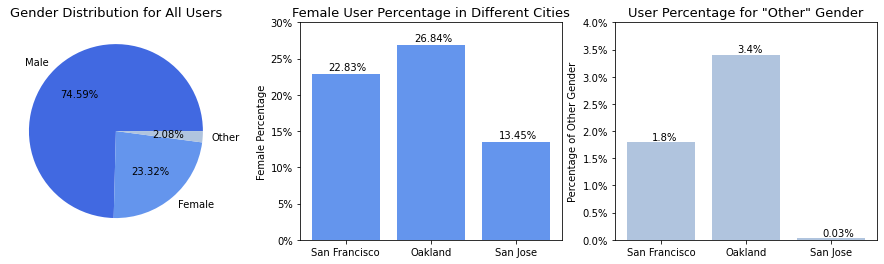

In [14]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 3, 1)
gender_count = df_clean1.member_gender.value_counts()
plt.pie(gender_count, labels=gender_count.index, autopct='%.2f%%', colors=colors);
plt.title('Gender Distribution for All Users', fontsize=13);

plt.subplot(1, 3, 2)
plt.bar(df_gender.index, df_gender.female, color='cornflowerblue');
plt.ylabel('Female Percentage');
plt.title('Female User Percentage in Different Cities', fontsize=13);
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]); # show y-axis as percentage
plt.ylim((0, 0.3))
for i in range(3):
    plt.text(i-0.2, df_gender.female[i]+0.01, str(round(100*df_gender.female[i], 2))+'%', va='center');

plt.subplot(1, 3, 3)
plt.bar(df_gender.index, df_gender.other, color='lightsteelblue');
plt.ylabel('Percentage of Other Gender');
plt.title('User Percentage for "Other" Gender', fontsize=13);
plt.gca().set_yticklabels(['{:.1f}%'.format(x*100) for x in plt.gca().get_yticks()]); # show y-axis as percentage
plt.ylim((0, 0.04))
for i in range(3):
    plt.text(i-0.1, df_gender.other[i]+0.001, str(round(100*df_gender.other[i], 2))+'%', va='center');

print('Male percentage for users:')
print('--------------------------')
for i in range(3):
    print(df_gender.index[i]+':', round(df_gender.male[i]*100, 2), '%')

## <font color='cornflowerblue'>GoBike User Gender</font>
### <font color='lightsteelblue'>Part 2</font>
> <li>Surprisingly, female users biking for longer time than male users, both on average or median values.</li><li>The users who put 'other' on gender actually biking for longest time, which is also quite interesting.</li><li>Since 75% users are recorded as men, their average biking duration might be decreased due to lots of small values under male users.</li>

*Outliers are removed in the boxplot, since there are too much of them.*

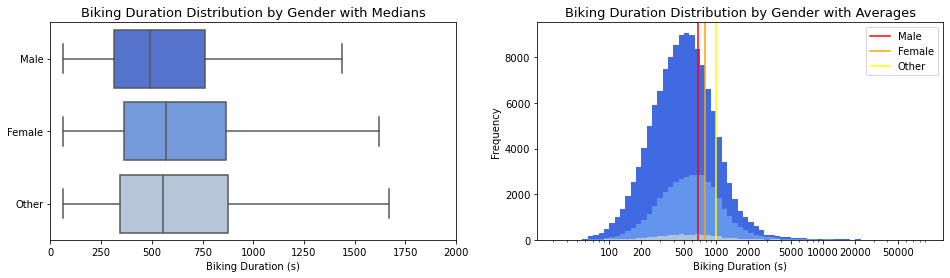

In [16]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1)
flierprops = dict(marker='')
gender = ['Male', 'Female', 'Other']
sb.boxplot(data=df_clean1, y='member_gender', x='duration_sec', order=gender,
           palette=colors, flierprops=flierprops); 
plt.xlim((0, 2000));
plt.ylabel('');
plt.xlabel('Biking Duration (s)');
plt.title('Biking Duration Distribution by Gender with Medians', fontsize=13);

plt.subplot(1, 2, 2)
avr = []
bins = 10**np.arange(1.5, 5, 0.05)
for i in range(3):
    a = df_clean1[df_clean1.member_gender == gender[i]]
    plt.hist(data = a, x = 'duration_sec', bins=bins, color=colors[i]);
    b = a.duration_sec.mean()
    avr.append(b)
    plt.axvline(b, color=colors1[i]);
plt.xscale('log')
ticks = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
labels = ['{}'.format(h) for h in ticks]
plt.xticks(ticks, labels);
plt.legend(avr, labels = gender);
plt.xlabel('Biking Duration (s)');
plt.ylabel('Frequency');
plt.title('Biking Duration Distribution by Gender with Averages', fontsize=13);

## <font color='cornflowerblue'>GoBike User Type</font>
> <li>Majority of GoBike users are subscribers, for almost 90%.</li><li>However, biking durations for customers are much higher than subscribers, no matter which city they are in.</li>

> <li>Users usually subscribe for a much lower rate, thus subscribers are frequent users.</li><li>Customers only use GoBike for temporarily, to compensate for their higher payment per ride, they tend to biking for relatively long time.</li>

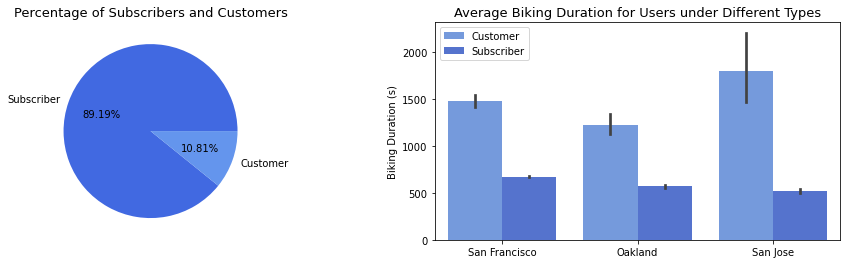

In [17]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1)
user_count = df_clean.user_type.value_counts()
plt.pie(user_count, labels=user_count.index, autopct='%.2f%%', colors=colors);
plt.title('Percentage of Subscribers and Customers', fontsize=13);

plt.subplot(1, 2, 2)
sb.barplot(data = df_clean, x = 'start_city', y = 'duration_sec', hue = 'user_type', palette=['cornflowerblue', 'royalblue']);
plt.legend(loc=2);
plt.xlabel('')
plt.ylabel('Biking Duration (s)');
plt.title('Average Biking Duration for Users under Different Types', fontsize=13);

## <font color='cornflowerblue'>GoBike Share</font>
> <li>Majority of GoBike trips are not shared, for almost 90%.</li><li>Only subscribers could share for all trip, customers can't.</li><li>During weekends, biking durations for unshared trips are apparently longer than shared trips and trips on weekdays.</li>

More long-time biking tours happened during weekends since people have more free time, and those users also have higher chance to be customers rather than subscribers, which resulted in longer unshared trip durations during weekends.

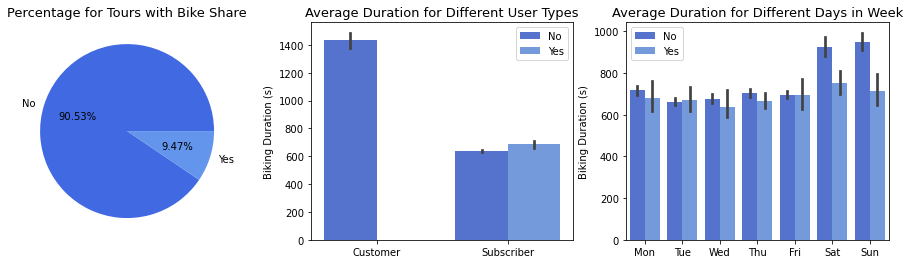

In [18]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 3, 1)
share_count = df_clean.bike_share_for_all_trip.value_counts()
plt.pie(share_count, labels=share_count.index, autopct='%.2f%%', colors=colors);
plt.title('Percentage for Tours with Bike Share', fontsize=13);

plt.subplot(1, 3, 2)
sb.barplot(data = df_clean, x = 'user_type', y = 'duration_sec', 
           hue = 'bike_share_for_all_trip', palette=colors);
plt.legend();
plt.xlabel('')
plt.ylabel('Biking Duration (s)');
plt.title('Average Duration for Different User Types', fontsize=13);

plt.subplot(1, 3, 3)
sb.barplot(data = df_clean, x = 'start_day', y = 'duration_sec', 
           hue = 'bike_share_for_all_trip', palette=colors);
plt.legend();
plt.xlabel('')
plt.ylabel('Biking Duration (s)');
plt.title('Average Duration for Different Days in Week', fontsize=13);
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']);

## <font color='cornflowerblue'>GoBike Stations</font>
### <font color='lightsteelblue'>Part 1</font>
> <li>All busiest stations are located in San Francisco.</li><li>Average bike tours per station is 1114.</li><li>Monthly bike tour numbers range from 8 to 8401.</li>

The busiest station id is 67, with bike tours of 8401, in the city of San Francisco
The loneliest station id is 344, with bike tours of 8, in the city of San Francisco
-----------------------------------------------------------------------------------
Average bike tours per station is 1114


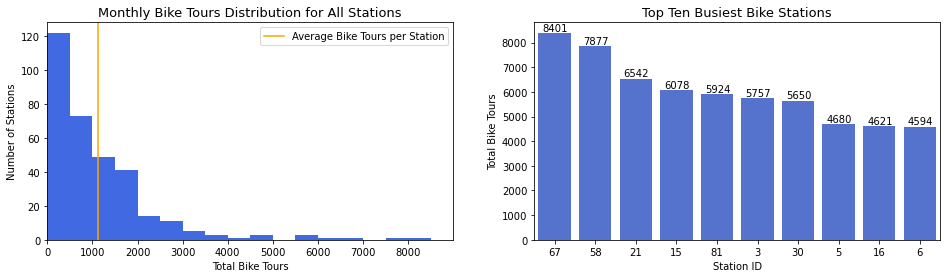

In [19]:
total_tour = df_station.sort_values(by=['total']).total
plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1)
bins = np.arange(0, 8600, 500)
ticks = np.arange(0, 9000, 1000)
plt.hist(total_tour, bins=bins, color=['royalblue']);
labels = ['{}'.format(h) for h in ticks]
plt.xticks(ticks, labels);
plt.xlabel('Total Bike Tours');
plt.ylabel('Number of Stations');
plt.title('Monthly Bike Tours Distribution for All Stations', fontsize=13);
avr = df_station.sort_values(by=['total']).total.mean()
plt.axvline(avr, color='orange');
plt.xlim((0, 9000))
plt.legend([avr], labels = ['Average Bike Tours per Station']);

max_tour = df_station.total.max()
max_id = df_station[df_station.total == max_tour].index[0]
max_city = df_station[df_station.total == max_tour].city[0]
print('The busiest station id is '+max_id+', with bike tours of '+str(max_tour)+', '+'in the city of '+max_city)

min_tour = df_station.total.min()
min_id = df_station[df_station.total == min_tour].index[0]
min_city = df_station[df_station.total == min_tour].city[0]
print('The loneliest station id is '+min_id+', with bike tours of '+str(min_tour)+', '+'in the city of '+min_city)

print('-----------------------------------------------------------------------------------')
print('Average bike tours per station is '+str(round(df_station.total.mean())))

plt.subplot(1, 2, 2)
top_ten = df_station.sort_values(by=['total'], ascending=False)[:10]
sb.barplot(top_ten.index, top_ten.total, color='royalblue');
plt.xlabel('Station ID');
plt.ylabel('Total Bike Tours');
plt.title('Top Ten Busiest Bike Stations', fontsize=13);
for i in range(10):
    plt.text(i-0.3, top_ten.total[i]+200, top_ten.total[i], va='center');

## <font color='cornflowerblue'>GoBike Stations</font>
### <font color='lightsteelblue'>Part 2</font>
> <li>For certain station, bike flow in if chosen as destination for a biking tour, and bike flow out if chosen as starting point.</li><li>High positive net bike flow value indicates a bike surplus.</li><li>Low negative net bike flow value indicates a bike shortage.</li>

> <li>Majority of stations don't have severe bike shortage or surplus, since their net bike flow in a month were between -100 to 100.</li><li>However, some stations have severe bike surplus or bike shortage.</li><li>The good new is, for all stations in each city listed, sums of their net bike flow are all 0, which means no bike got stolen.

Stations Under Severe Bike Surplus:

id: 67, surplus: 1313, city: San Francisco
id: 21, surplus: 752, city: San Francisco
id: 15, surplus: 658, city: San Francisco
-------------------------------------------
Stations Under Severe Bike Shortage:

id: 243, shortage: -646, city: Oakland
id: 253, shortage: -324, city: Oakland
id: 22, shortage: -259, city: San Francisco


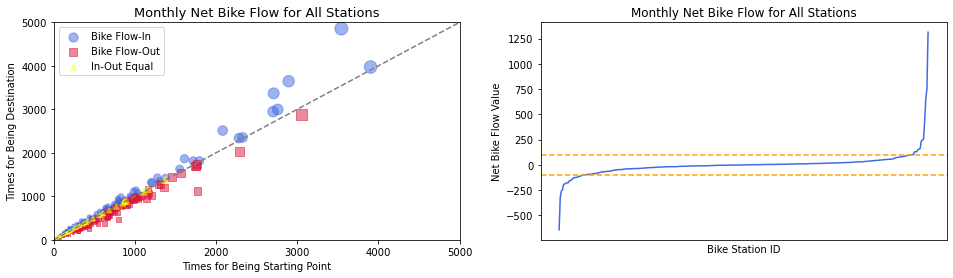

In [20]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 2, 1)
mks = [['in', 'o', 'royalblue'], ['out', 's', 'crimson'], ['equal', '^', 'yellow']]
for i, v, h in mks:
    data = df_station[df_station['type'] == i]
    plt.scatter(data.start, data.end, marker = v, alpha=0.5, c=h, s=data.total/50);
plt.legend(['Bike Flow-In','Bike Flow-Out', 'In-Out Equal']);
plt.xlabel('Times for Being Starting Point');
plt.ylabel('Times for Being Destination');
plt.title('Monthly Net Bike Flow for All Stations', fontsize=13);
plt.xlim((0, 5000));
plt.ylim((0, 5000));
plt.plot([0, 5000], [0, 5000], ls='--', c='.5');

plt.subplot(1, 2, 2)
df_station.sort_values(by=['net']).net.plot(kind='line', color='royalblue');
plt.xticks([]);
plt.xlabel('');
plt.axhline(100, color='orange', ls='--');
plt.axhline(-100, color='orange', ls='--');
plt.xlabel('Bike Station ID');
plt.ylabel('Net Bike Flow Value');
plt.title('Monthly Net Bike Flow for All Stations');

print('Stations Under Severe Bike Surplus:')
print('')
for i in range(3):
    large = df_station.net.nlargest(3)
    id = large.index[i]
    print('id: '+id+', surplus: '+str(large[i])+', '+'city: '+df_station.city[id])
print('-------------------------------------------')
print('Stations Under Severe Bike Shortage:')
print('')
for i in range(3):
    small = df_station.net.nsmallest(3)
    id = small.index[i]
    print('id: '+id+', shortage: '+str(small[i])+', '+'city: '+df_station.city[id])

## <font color='cornflowerblue'>Busiest Station: No.67</font>
> <li>No.67 bike station in San Francisco has the most bike tour numbers.</li><li>Five bike stations have strong connection to No.67, and they are: No.90, No.58, No.89, No.61 and No.21.</li><li>For the stations mentioned above, lots of bikes from No.67 visited them, and lots of bikes from them visited No.67.</li>

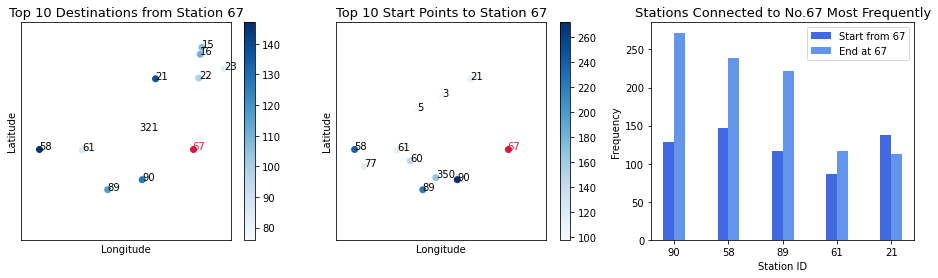

In [21]:
plt.figure(figsize=(16, 4));

plt.subplot(1, 3, 1)
data_start = df_clean[df_clean.start_station_id == '67']
longi = data_start.groupby(['end_station_id']).end_station_longitude.mean().to_frame()
lati = data_start.groupby(['end_station_id']).end_station_latitude.mean()
name = data_start.end_station_id.value_counts()
dataset_start = pd.concat([name, longi, lati], axis=1)
dataset_start.rename(columns={'end_station_id':'frequency', 
                              'end_station_longitude':'longi', 'end_station_latitude':'lati'}, inplace=True)
data = dataset_start[:10]
plt.scatter(data.longi, data.lati, c=data.frequency, cmap = 'Blues');
plt.colorbar();
plt.scatter(df_station.loc['67'].longi, df_station.loc['67'].lati, color = 'crimson')
for i, txt in enumerate(data.index):
    plt.annotate(txt, (data.longi[i], data.lati[i]))
plt.annotate('67', (df_station.loc['67'].longi, df_station.loc['67'].lati), color = 'crimson')
plt.xlim((-122.42, -122.39))
plt.ylim((37.76, 37.8))
plt.xticks([]);
plt.yticks([]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.title('Top 10 Destinations from Station 67', fontsize=13);

plt.subplot(1, 3, 2)
data_end = df_clean[df_clean.end_station_id == '67']
longi = data_end.groupby(['start_station_id']).start_station_longitude.mean().to_frame()
lati = data_end.groupby(['start_station_id']).start_station_latitude.mean()
name = data_end.start_station_id.value_counts()
dataset_end = pd.concat([name, longi, lati], axis=1)
dataset_end.rename(columns={'start_station_id':'frequency', 
                              'start_station_longitude':'longi', 'start_station_latitude':'lati'}, inplace=True)
data = dataset_end[:10]
plt.scatter(data.longi, data.lati, c=data.frequency, cmap = 'Blues');
plt.colorbar();
plt.scatter(df_station.loc['67'].longi, df_station.loc['67'].lati, color = 'crimson')
for i, txt in enumerate(data.index):
    plt.annotate(txt, (data.longi[i], data.lati[i]))
plt.annotate('67', (df_station.loc['67'].longi, df_station.loc['67'].lati), color = 'crimson')
plt.xlim((-122.42, -122.39))
plt.ylim((37.76, 37.8))
plt.xticks([]);
plt.yticks([]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.title('Top 10 Start Points to Station 67', fontsize=13);

plt.subplot(1, 3, 3)
a = data_end.start_station_id.value_counts().index[:10]
b = data_start.end_station_id.value_counts().index[:10]
c = []
for i in range(len(a)):
    for v in range(len(b)):
        if a[i] == b[v]:
            c.append(a[i])
data1 = dataset_end.loc[c, 'frequency']
data2 = dataset_start.loc[c, 'frequency']
data0 = {'end':data1}
df_busy = pd.DataFrame(data0, columns = ['end'])
df_busy['start'] = data2
plt.bar(np.arange(1, 5.5, 1)-0.1, df_busy.start, width=0.2, color='royalblue');
plt.bar(np.arange(1, 5.5, 1)+0.1, df_busy.end, width=0.2, color='cornflowerblue');
plt.xticks(np.arange(1, 5.5, 1), df_busy.index);
plt.legend(labels = ['Start from 67', 'End at 67']);
plt.xlabel('Station ID');
plt.ylabel('Frequency');
plt.title('Stations Connected to No.67 Most Frequently', fontsize=13);

## <font color='cornflowerblue'>Busiest Bike: No.4794</font>
> <li>Bike No.4794 is the busiest one, with 191 tours involved.</li><li>There are 83 "unlucky" bikes that were only used for once.</li><li>The good news is, all bikes was used for at least once.</li><li>On average, bike was used for 40 times in Feb 2019.</li>

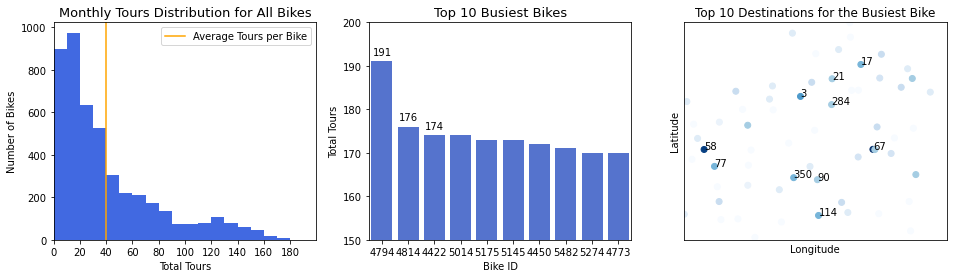

In [22]:
total_tour = df_clean.sort_values(by=['bike_id']).bike_id.value_counts()
plt.figure(figsize=(16, 4));

plt.subplot(1, 3, 1)
bins = np.arange(0, 200, 10)
ticks = np.arange(0, 200, 20)
plt.hist(total_tour, bins=bins, color=['royalblue']);
labels = ['{}'.format(h) for h in ticks]
plt.xticks(ticks, labels);
plt.xlabel('Total Tours');
plt.ylabel('Number of Bikes');
plt.title('Monthly Tours Distribution for All Bikes', fontsize=13);
avr = total_tour.mean()
plt.axvline(avr, color='orange');
plt.xlim((0, 200))
plt.legend([avr], labels = ['Average Tours per Bike']);

plt.subplot(1, 3, 2)
top_ten = total_tour[:10]
sb.barplot(top_ten.index, top_ten, color='royalblue');
plt.xlabel('Bike ID');
plt.ylabel('Total Tours');
plt.title('Top 10 Busiest Bikes', fontsize=13);
plt.ylim((150, 200));
for i in range(3):
    plt.text(i-0.35, top_ten[i]+1.5, top_ten[i]);
    
plt.subplot(1, 3, 3)
a = df_clean[df_clean.bike_id == '4794'].start_station_id.value_counts()
b = df_clean[df_clean.bike_id == '4794'].end_station_id.value_counts()
freq = pd.merge(a, b, left_index=True, right_index=True)
freq['total_visit'] = freq['start_station_id']+freq['end_station_id']
data = {'frequency':freq['total_visit']}
df_bike = pd.DataFrame(data, columns = ['frequency'])
df_bike['longi'] = df_station.loc[freq.index, 'longi']
df_bike['lati'] = df_station.loc[freq.index, 'lati']
plt.scatter(df_bike.longi, df_bike.lati, c=df_bike.frequency, cmap = 'Blues');
for i, txt in enumerate(df_bike.index[:10]):
    plt.annotate(txt, (df_bike.longi[i], df_bike.lati[i]))
plt.xticks([]);
plt.yticks([]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.title('Top 10 Destinations for the Busiest Bike');
plt.xlim((-122.42, -122.386));
plt.ylim((37.76, 37.8));

## <font color='cornflowerblue'>Conclusions</font>
> <li>Ford GoBike is most frequently used in San Francisco.</li><li>Few bikes and stations were very frequently used, but most of them were not.</li><li>On average, a bike can be used 1.3 times per day, a station can be used 35 times a day.</li><li>Few popular bike stations have severe bike shortage or surplus, measures needed to be carried out to solve the inequality.</li><li>Most people ride bike for 8-10 minutes each time, and 75% users are young male between 25-35 years old.</li><li>But, there are also people ride bikes for more than 10 hours, regular quality check is needed based on bike's frequency to be used.</li>

# <font color='royalblue'>THANKS</font>